# Impact of Hedging Volatility on Option P&L

In this notebook, we investigate the hedged P&L of an option using different strategies.

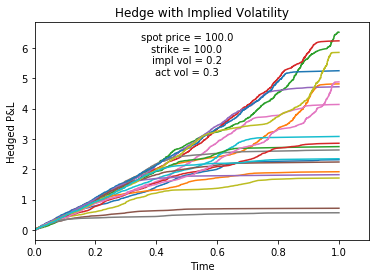

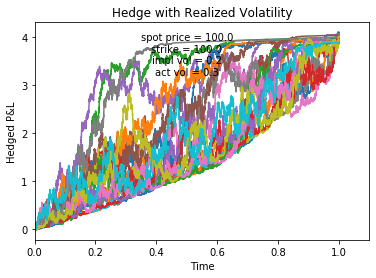

In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

def option_price(spot, strike, vol, tau, r, phi):
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    d2 = d1 - var

    v1 = scipy.stats.norm.cdf(phi * d1)
    v2 = scipy.stats.norm.cdf(phi * d2)

    price = phi * (spot * v1 - strike * np.exp(-r * tau) * v2)

    return price


def option_delta(spot, strike, vol, tau, r, phi):
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    v1 = scipy.stats.norm.cdf(phi * d1)

    delta = phi * v1

    return delta


def hedge_pnl_sim_single(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep):
    '''
        This function simulates one sample path for underlying prices and compute delta hedged pnl of an option.
        
        implied_vol: implied volatility which market is using to price an option
        realized_vol: actual volatility for the underlying prices
        hedge_vol: volatility that is used for computing the hedge delta
        phi: 1.0 for call option and -1.0 for put option
    '''
    
    dt = tau / nstep
    taus = np.array([tau - dt * i for i in range(nstep)])

    # simulate underlying prices
    rvs = scipy.stats.norm.rvs(size=nstep - 1)
    ds = np.exp((r - 0.5 * realized_vol**2) * dt + realized_vol * np.sqrt(dt) * rvs)
    prices = np.insert(ds, 0, spot)
    prices = prices.cumprod()

    # compute option prices using implied vol and deltas for hedging using hedge vol.
    option_prices = option_price(prices, strike, implied_vol, taus, r, phi)
    hedge_deltas = option_delta(prices, strike, hedge_vol, taus, r, phi)

    # calculate value of hedged option excluding the initial premium paid for the option (see reference paper for the formula)
    hedged_value = [0.0] * nstep
    hedged_value[0] = hedge_deltas[0] * prices[0]
    for i in range(1, nstep):
        hedged_value[i] = hedged_value[i - 1] * np.exp(r * dt) + (hedge_deltas[i] - hedge_deltas[i-1]) * prices[i]
    for i in range(nstep):
        hedged_value[i] += option_prices[i] - hedge_deltas[i] * prices[i]

    # calculate pnl: hedged value - initial premium on option plus interest
    hedged_pnl = [0.0] * nstep
    for i in range(nstep):
        hedged_pnl[i] = hedged_value[i] - option_prices[0] * np.exp(r * i * dt)

    return hedged_pnl


def hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, nsim):
    '''
        Simulate hedged P&L for options
    '''
    pnls = []
    for i in range(nsim):
        hedged_pnl = hedge_pnl_sim_single(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep)
        pnls.append(hedged_pnl)

    return pnls


def plot_hedge_pnl(hedge_with_implied_vol=True):
    spot = 100.0
    strike = 100.0
    r = 0.05
    tau = 1.0
    implied_vol = 0.2
    realized_vol = 0.3
    hedge_vol = implied_vol if hedge_with_implied_vol else realized_vol
    phi = 1.0
    nstep = 10000

    pnls = hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, 20)

    # plot hedged pnl
    plt.xlim(0, 1.1)
    plt.xlabel('Time')
    plt.ylabel('Hedged P&L')
    if hedge_with_implied_vol:
        plt.title('Hedge with Implied Volatility')
    else:
        plt.title('Hedge with Realized Volatility')
        
    max_pnl = np.max([np.max(pnl) for pnl in pnls])
    annotations = 'spot price = {}'.format(spot)
    annotations += '\n'
    annotations += 'strike = {}'.format(strike)
    annotations += '\n'
    annotations += 'impl vol = {}'.format(implied_vol)
    annotations += '\n'
    annotations += 'act vol = {}'.format(realized_vol)
    plt.annotate(annotations, xy=(0.5, max_pnl), va='top', ha='center')

    ts = np.linspace(0, tau, nstep)
    for pnl in pnls:
        plt.plot(ts, pnl)

    plt.show()

    
def plot_discrete_hedge_pnl():
    # hedge with implied vol
    spot = 100.0
    strike = 100.0
    r = 0.0
    tau = 1.0 / 12
    implied_vol = 0.2
    realized_vol = 0.2
    hedge_vol = implied_vol
    phi = 1.0
    nstep = 84
    nsim = 10000

    pnls = hedge_pnl_sim(spot, strike, r, tau, implied_vol, realized_vol, hedge_vol, phi, nstep, nsim)
    pnls = np.array([pnl[-1] for pnl in pnls])

    n, bins, patches = plt.hist(pnls, 20, density=True, alpha=0.75)

    plt.xlabel('Final P&L')
    plt.ylabel('Probability')
    plt.title('Discrete Hedge P&L')
    plt.text(bins[0] * 1.1, np.max(n), r'$\mu={:.4f},\ \sigma={:.2f}$'.format(np.mean(pnls), np.std(pnls)))

    plt.show()

plot_hedge_pnl(hedge_with_implied_vol=True)
plot_hedge_pnl(hedge_with_implied_vol=False)
plot_discrete_hedge_pnl()